# Mobilenet 3 Channel
https://www.kaggle.com/kmmohsin/4-beginners-convnet-in-tf-memory-savings
https://www.kaggle.com/amneves/quick-draw-keras-cnn-model

In [23]:
import warnings
warnings.filterwarnings('ignore')

import ast
import math
import pandas as pd
import glob
import numpy as np
import cv2

from simplification.cutil import simplify_coords

import matplotlib.pyplot as plt
import matplotlib.style as style

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import json
import os
import datetime as dt
from tqdm import tqdm
import pandas as pd
import numpy as np
from glob import glob
import re
import ast
import cv2
import csv
import time
import ast
import urllib
from PIL import Image, ImageDraw
from tqdm import tqdm
from dask import bag, threaded
import matplotlib
import matplotlib.pyplot as pltc
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
from dask import bag, threaded
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.nasnet import NASNetMobile
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.applications import MobileNet

Base_Size = 256
data_Directory = 'C:/Users/wangy/OneDrive/Desktop/Doodle/Doodle_Data'
input_Directory = 'C:/Users/wangy/OneDrive/Desktop/Doodle/Prediction/'
sub_Directory = 'D:/APM/'
num_csv = 100
num_class = 340
size = 64
import os

print(os.listdir("C:/Users/wangy/OneDrive/Desktop/Doodle"))

['.ipynb_checkpoints', 'Doodle_Data', 'Graphs', 'Models', 'Prediction', 'Screenshot']


In [7]:
#Test
def draw_cv2(raw_strokes, size=size, lw=6):
    img = np.zeros((Base_Size, Base_Size))
    for stroke in raw_strokes:
        for i in range(len(stroke[0]) - 1):
            img = cv2.line(img, (stroke[0][i], stroke[1][i]), (stroke[0][i + 1], stroke[1][i + 1]), 255, lw)
    return (cv2.resize(img, (size, size))/ 255.)

#Data Augmentation
def image_generator(size, batchsize, ks, lw=6):
    while True:
        for k in np.random.permutation(ks):
            filename = os.path.join(data_Directory, 'train_k{}.csv.gz'.format(k))
            for df in pd.read_csv(filename, chunksize=batchsize):
                x = np.zeros((len(df), size, size))
                df['drawing'] = [ast.literal_eval(pts) for pts in df['drawing'].values]   
                df['drawing'] = df['drawing'].apply(draw_cv2)
                x = np.vstack([a for a in df['drawing']]).reshape((len(df),size,size,1))
                y = tf.keras.utils.to_categorical(df.y, num_classes=num_class)
                yield x, y
                  

def df_to_image_array(df, size=size, lw=6):
    df['drawing'] = [ast.literal_eval(pts) for pts in df['drawing'].values]
    x = np.zeros((len(df), size, size))
    df['drawing'] = df['drawing'].apply(draw_cv2)
    x = np.vstack([a for a in df['drawing']]).reshape((len(df),size,size,1))
    return x

In [8]:
steps = 2000
batchsize = 256
epochs = 250

In [9]:
valid_df = pd.read_csv(os.path.join(data_Directory, 'train_k{}.csv.gz'.format(num_csv - 1)), nrows=30000)
x_valid = df_to_image_array(valid_df, size)
y_valid = tf.keras.utils.to_categorical(valid_df.y, num_classes=num_class)
print(x_valid.shape, y_valid.shape)

(30000, 64, 64, 1) (30000, 340)


In [10]:
train_datagen = image_generator(size=size, batchsize=batchsize, ks=range(num_csv - 1))

In [11]:
def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [12]:
model = MobileNet(input_shape=(size, size, 1), alpha=1, weights=None, classes=num_class)
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy])
print(model.summary())

Model: "mobilenet_1.00_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 65, 65, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        288       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 32, 32, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 32, 32, 32)  

In [13]:
callbacks = [
    ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.3, patience=5,
                      min_delta=0.005, mode='max', verbose=1),
    ModelCheckpoint('MobileNet.h5', monitor='val_top_3_accuracy', mode='max', save_best_only=True, save_weights_only=True)
]


clf = model.fit(
    train_datagen, steps_per_epoch=steps, epochs=epochs, verbose=1,
    validation_data=(x_valid, y_valid),
    callbacks = callbacks
)

Epoch 1/250
2000/2000 [==============================] - 244s 122ms/step - loss: 2.9098 - categorical_crossentropy: 2.9098 - categorical_accuracy: 0.3527 - top_3_accuracy: 0.5367 - val_loss: 2.4423 - val_categorical_crossentropy: 2.4423 - val_categorical_accuracy: 0.4332 - val_top_3_accuracy: 0.6551
Epoch 2/250
2000/2000 [==============================] - 244s 122ms/step - loss: 1.7354 - categorical_crossentropy: 1.7354 - categorical_accuracy: 0.5749 - top_3_accuracy: 0.7737 - val_loss: 1.6821 - val_categorical_crossentropy: 1.6821 - val_categorical_accuracy: 0.5845 - val_top_3_accuracy: 0.7834
Epoch 3/250
2000/2000 [==============================] - 245s 122ms/step - loss: 1.4994 - categorical_crossentropy: 1.4994 - categorical_accuracy: 0.6272 - top_3_accuracy: 0.8144 - val_loss: 1.4763 - val_categorical_crossentropy: 1.4763 - val_categorical_accuracy: 0.6311 - val_top_3_accuracy: 0.8174
Epoch 4/250
2000/2000 [==============================] - 242s 121ms/step - loss: 1.3808 - categor

2000/2000 [==============================] - ETA: 0s - loss: 0.9531 - categorical_crossentropy: 0.9531 - categorical_accuracy: 0.7553 - top_3_accuracy: 0.8989
Epoch 00028: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
2000/2000 [==============================] - 245s 122ms/step - loss: 0.9531 - categorical_crossentropy: 0.9531 - categorical_accuracy: 0.7553 - top_3_accuracy: 0.8989 - val_loss: 0.9600 - val_categorical_crossentropy: 0.9600 - val_categorical_accuracy: 0.7536 - val_top_3_accuracy: 0.8968
Epoch 29/250
2000/2000 [==============================] - 245s 123ms/step - loss: 0.9074 - categorical_crossentropy: 0.9074 - categorical_accuracy: 0.7675 - top_3_accuracy: 0.9051 - val_loss: 0.8938 - val_categorical_crossentropy: 0.8938 - val_categorical_accuracy: 0.7707 - val_top_3_accuracy: 0.9062
Epoch 30/250
2000/2000 [==============================] - 244s 122ms/step - loss: 0.8854 - categorical_crossentropy: 0.8854 - categorical_accuracy: 0.7720 - top_3_accurac

2000/2000 [==============================] - 245s 123ms/step - loss: 0.8100 - categorical_crossentropy: 0.8100 - categorical_accuracy: 0.7911 - top_3_accuracy: 0.9172 - val_loss: 0.8467 - val_categorical_crossentropy: 0.8467 - val_categorical_accuracy: 0.7813 - val_top_3_accuracy: 0.9130
Epoch 52/250
2000/2000 [==============================] - 244s 122ms/step - loss: 0.8093 - categorical_crossentropy: 0.8093 - categorical_accuracy: 0.7911 - top_3_accuracy: 0.9178 - val_loss: 0.8466 - val_categorical_crossentropy: 0.8466 - val_categorical_accuracy: 0.7811 - val_top_3_accuracy: 0.9130
Epoch 53/250
2000/2000 [==============================] - 244s 122ms/step - loss: 0.8054 - categorical_crossentropy: 0.8054 - categorical_accuracy: 0.7914 - top_3_accuracy: 0.9183 - val_loss: 0.8465 - val_categorical_crossentropy: 0.8465 - val_categorical_accuracy: 0.7812 - val_top_3_accuracy: 0.9131
Epoch 54/250
2000/2000 [==============================] - 245s 122ms/step - loss: 0.7945 - categorical_cros

Epoch 75/250
2000/2000 [==============================] - ETA: 0s - loss: 0.8032 - categorical_crossentropy: 0.8032 - categorical_accuracy: 0.7921 - top_3_accuracy: 0.9185
Epoch 00075: ReduceLROnPlateau reducing learning rate to 5.904900035602622e-09.
2000/2000 [==============================] - 244s 122ms/step - loss: 0.8032 - categorical_crossentropy: 0.8032 - categorical_accuracy: 0.7921 - top_3_accuracy: 0.9185 - val_loss: 0.8465 - val_categorical_crossentropy: 0.8465 - val_categorical_accuracy: 0.7809 - val_top_3_accuracy: 0.9131
Epoch 76/250
2000/2000 [==============================] - 243s 122ms/step - loss: 0.7984 - categorical_crossentropy: 0.7984 - categorical_accuracy: 0.7926 - top_3_accuracy: 0.9190 - val_loss: 0.8464 - val_categorical_crossentropy: 0.8464 - val_categorical_accuracy: 0.7808 - val_top_3_accuracy: 0.9130
Epoch 77/250
2000/2000 [==============================] - 245s 122ms/step - loss: 0.7870 - categorical_crossentropy: 0.7870 - categorical_accuracy: 0.7968 - 

2000/2000 [==============================] - 245s 123ms/step - loss: 0.7944 - categorical_crossentropy: 0.7944 - categorical_accuracy: 0.7942 - top_3_accuracy: 0.9196 - val_loss: 0.8463 - val_categorical_crossentropy: 0.8463 - val_categorical_accuracy: 0.7810 - val_top_3_accuracy: 0.9131
Epoch 99/250
2000/2000 [==============================] - 245s 123ms/step - loss: 0.7994 - categorical_crossentropy: 0.7994 - categorical_accuracy: 0.7932 - top_3_accuracy: 0.9190 - val_loss: 0.8465 - val_categorical_crossentropy: 0.8465 - val_categorical_accuracy: 0.7810 - val_top_3_accuracy: 0.9132
Epoch 100/250
2000/2000 [==============================] - ETA: 0s - loss: 0.7911 - categorical_crossentropy: 0.7911 - categorical_accuracy: 0.7948 - top_3_accuracy: 0.9198
Epoch 00100: ReduceLROnPlateau reducing learning rate to 1.434890747886719e-11.
2000/2000 [==============================] - 245s 123ms/step - loss: 0.7911 - categorical_crossentropy: 0.7911 - categorical_accuracy: 0.7948 - top_3_accura

2000/2000 [==============================] - 242s 121ms/step - loss: 0.7998 - categorical_crossentropy: 0.7998 - categorical_accuracy: 0.7933 - top_3_accuracy: 0.9189 - val_loss: 0.8465 - val_categorical_crossentropy: 0.8465 - val_categorical_accuracy: 0.7806 - val_top_3_accuracy: 0.9129
Epoch 122/250
2000/2000 [==============================] - 242s 121ms/step - loss: 0.8022 - categorical_crossentropy: 0.8022 - categorical_accuracy: 0.7930 - top_3_accuracy: 0.9183 - val_loss: 0.8464 - val_categorical_crossentropy: 0.8464 - val_categorical_accuracy: 0.7809 - val_top_3_accuracy: 0.9131
Epoch 123/250
2000/2000 [==============================] - 243s 121ms/step - loss: 0.7909 - categorical_crossentropy: 0.7909 - categorical_accuracy: 0.7943 - top_3_accuracy: 0.9201 - val_loss: 0.8463 - val_categorical_crossentropy: 0.8463 - val_categorical_accuracy: 0.7806 - val_top_3_accuracy: 0.9129
Epoch 124/250
2000/2000 [==============================] - 242s 121ms/step - loss: 0.7905 - categorical_c

Epoch 145/250
2000/2000 [==============================] - ETA: 0s - loss: 0.8065 - categorical_crossentropy: 0.8065 - categorical_accuracy: 0.7919 - top_3_accuracy: 0.9178
Epoch 00145: ReduceLROnPlateau reducing learning rate to 2.8242954138314303e-16.
2000/2000 [==============================] - 242s 121ms/step - loss: 0.8065 - categorical_crossentropy: 0.8065 - categorical_accuracy: 0.7919 - top_3_accuracy: 0.9178 - val_loss: 0.8462 - val_categorical_crossentropy: 0.8462 - val_categorical_accuracy: 0.7806 - val_top_3_accuracy: 0.9132
Epoch 146/250
2000/2000 [==============================] - 243s 121ms/step - loss: 0.8141 - categorical_crossentropy: 0.8141 - categorical_accuracy: 0.7894 - top_3_accuracy: 0.9170 - val_loss: 0.8463 - val_categorical_crossentropy: 0.8463 - val_categorical_accuracy: 0.7805 - val_top_3_accuracy: 0.9130
Epoch 147/250
2000/2000 [==============================] - 241s 121ms/step - loss: 0.7855 - categorical_crossentropy: 0.7855 - categorical_accuracy: 0.797

2000/2000 [==============================] - 243s 122ms/step - loss: 0.7949 - categorical_crossentropy: 0.7949 - categorical_accuracy: 0.7943 - top_3_accuracy: 0.9195 - val_loss: 0.8462 - val_categorical_crossentropy: 0.8462 - val_categorical_accuracy: 0.7805 - val_top_3_accuracy: 0.9130
Epoch 169/250
2000/2000 [==============================] - 244s 122ms/step - loss: 0.7983 - categorical_crossentropy: 0.7983 - categorical_accuracy: 0.7933 - top_3_accuracy: 0.9192 - val_loss: 0.8463 - val_categorical_crossentropy: 0.8463 - val_categorical_accuracy: 0.7810 - val_top_3_accuracy: 0.9128
Epoch 170/250
2000/2000 [==============================] - ETA: 0s - loss: 0.7879 - categorical_crossentropy: 0.7879 - categorical_accuracy: 0.7954 - top_3_accuracy: 0.9202
Epoch 00170: ReduceLROnPlateau reducing learning rate to 6.863037719423359e-19.
2000/2000 [==============================] - 245s 122ms/step - loss: 0.7879 - categorical_crossentropy: 0.7879 - categorical_accuracy: 0.7954 - top_3_accur

2000/2000 [==============================] - 244s 122ms/step - loss: 0.8108 - categorical_crossentropy: 0.8108 - categorical_accuracy: 0.7904 - top_3_accuracy: 0.9175 - val_loss: 0.8463 - val_categorical_crossentropy: 0.8463 - val_categorical_accuracy: 0.7811 - val_top_3_accuracy: 0.9131
Epoch 192/250
2000/2000 [==============================] - 243s 122ms/step - loss: 0.7991 - categorical_crossentropy: 0.7991 - categorical_accuracy: 0.7928 - top_3_accuracy: 0.9190 - val_loss: 0.8463 - val_categorical_crossentropy: 0.8463 - val_categorical_accuracy: 0.7809 - val_top_3_accuracy: 0.9133
Epoch 193/250
2000/2000 [==============================] - 242s 121ms/step - loss: 0.7874 - categorical_crossentropy: 0.7874 - categorical_accuracy: 0.7952 - top_3_accuracy: 0.9204 - val_loss: 0.8464 - val_categorical_crossentropy: 0.8464 - val_categorical_accuracy: 0.7809 - val_top_3_accuracy: 0.9128
Epoch 194/250
2000/2000 [==============================] - 243s 122ms/step - loss: 0.7954 - categorical_c

Epoch 215/250
2000/2000 [==============================] - ETA: 0s - loss: 0.7998 - categorical_crossentropy: 0.7998 - categorical_accuracy: 0.7941 - top_3_accuracy: 0.9190
Epoch 00215: ReduceLROnPlateau reducing learning rate to 1.350851851205447e-23.
2000/2000 [==============================] - 244s 122ms/step - loss: 0.7998 - categorical_crossentropy: 0.7998 - categorical_accuracy: 0.7941 - top_3_accuracy: 0.9190 - val_loss: 0.8463 - val_categorical_crossentropy: 0.8463 - val_categorical_accuracy: 0.7808 - val_top_3_accuracy: 0.9129
Epoch 216/250
2000/2000 [==============================] - 245s 122ms/step - loss: 0.8005 - categorical_crossentropy: 0.8005 - categorical_accuracy: 0.7931 - top_3_accuracy: 0.9188 - val_loss: 0.8462 - val_categorical_crossentropy: 0.8462 - val_categorical_accuracy: 0.7813 - val_top_3_accuracy: 0.9130
Epoch 217/250
2000/2000 [==============================] - 245s 122ms/step - loss: 0.8172 - categorical_crossentropy: 0.8172 - categorical_accuracy: 0.7897

2000/2000 [==============================] - 245s 122ms/step - loss: 0.8101 - categorical_crossentropy: 0.8101 - categorical_accuracy: 0.7909 - top_3_accuracy: 0.9178 - val_loss: 0.8463 - val_categorical_crossentropy: 0.8463 - val_categorical_accuracy: 0.7807 - val_top_3_accuracy: 0.9127
Epoch 239/250
2000/2000 [==============================] - 245s 122ms/step - loss: 0.8021 - categorical_crossentropy: 0.8021 - categorical_accuracy: 0.7927 - top_3_accuracy: 0.9185 - val_loss: 0.8464 - val_categorical_crossentropy: 0.8464 - val_categorical_accuracy: 0.7813 - val_top_3_accuracy: 0.9131
Epoch 240/250
2000/2000 [==============================] - ETA: 0s - loss: 0.7993 - categorical_crossentropy: 0.7993 - categorical_accuracy: 0.7932 - top_3_accuracy: 0.9190
Epoch 00240: ReduceLROnPlateau reducing learning rate to 3.28257003487461e-26.
2000/2000 [==============================] - 243s 122ms/step - loss: 0.7993 - categorical_crossentropy: 0.7993 - categorical_accuracy: 0.7932 - top_3_accura

In [16]:
def plot_graph(clf, title):
    plt.plot(clf.history['categorical_accuracy'])
    plt.plot(clf.history['val_categorical_accuracy'])
    plt.plot(clf.history['top_3_accuracy'])
    plt.plot(clf.history['val_top_3_accuracy'])
    plt.title('Accuracy ' + title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation', 'Test Top 3', 'Validation Top 3'], loc='lower right')
    plt.show()
    plt.plot(clf.history['categorical_crossentropy'])
    plt.plot(clf.history['val_categorical_crossentropy'])
    plt.title('Loss ' + title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()

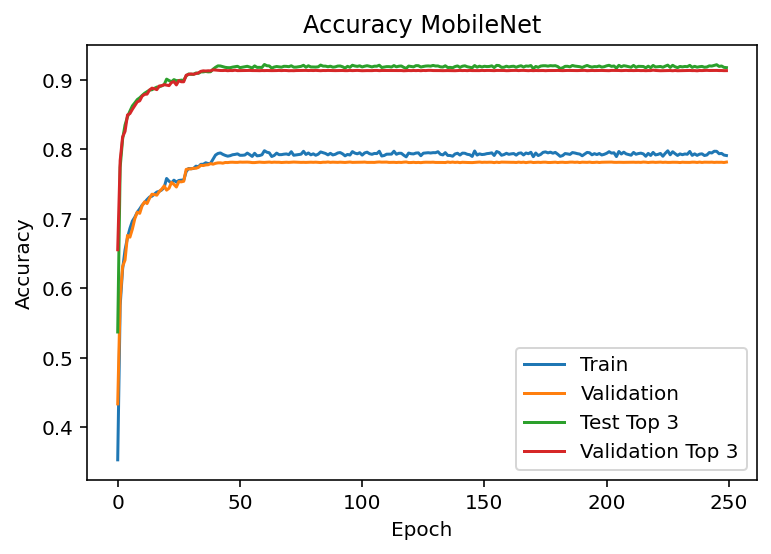

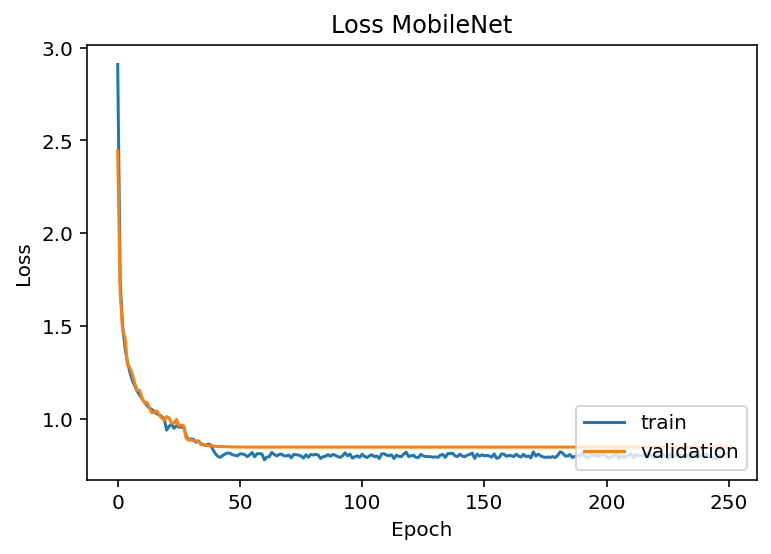

In [17]:
plot_graph(clf, "MobileNet")

# Turn in Kaggle

In [25]:
pred_results = []
chunksize = 10000
reader = pd.read_csv(input_Directory + 'test_simplified.csv', chunksize=chunksize)
for chunk in tqdm(reader):
    imgs = df_to_image_array(chunk)
    pred = model.predict(imgs, verbose=1)
    top_3 =  np.argsort(-pred)[:, 0:3]  
    pred_results.append(top_3)
print("Finished test predictions...")

0it [00:00, ?it/s]

313/313 [==============================] - 1s 3ms/step


1it [00:07,  7.17s/it]

313/313 [==============================] - 1s 3ms/step


2it [00:13,  7.03s/it]

313/313 [==============================] - 1s 3ms/step


3it [00:20,  6.86s/it]

313/313 [==============================] - 1s 3ms/step


4it [00:26,  6.77s/it]

313/313 [==============================] - 1s 3ms/step


5it [00:33,  6.71s/it]

313/313 [==============================] - 1s 3ms/step


6it [00:39,  6.63s/it]

313/313 [==============================] - 1s 3ms/step


7it [00:46,  6.58s/it]

313/313 [==============================] - 1s 3ms/step


8it [00:52,  6.57s/it]

313/313 [==============================] - 1s 3ms/step


9it [00:59,  6.54s/it]

313/313 [==============================] - 1s 3ms/step


10it [01:05,  6.54s/it]

313/313 [==============================] - 1s 3ms/step


11it [01:12,  6.56s/it]

69/69 [==============================] - 0s 5ms/step


12it [01:14,  6.18s/it]

Finished test predictions...


In [26]:
#prepare data for saving
classes_path = os.listdir(sub_Directory + 'train_simplified/')
classes_path = sorted(classes_path, key=lambda s: s.lower())
class_dict = {x[:-4].replace(" ", "_"):i for i, x in enumerate(classes_path)}

reverse_dict = {v: k for k, v in class_dict.items()}
pred_results = np.concatenate(pred_results)
print("Finished data prep...")

Finished data prep...


In [27]:
preds_df = pd.DataFrame({'first': pred_results[:,0], 'second': pred_results[:,1], 'third': pred_results[:,2]})
preds_df = preds_df.replace(reverse_dict)

In [28]:
preds_df['words'] = preds_df['first'] + " " + preds_df['second'] + " " + preds_df['third']

sub = pd.read_csv(input_Directory + 'sample_submission.csv', index_col=['key_id'])
sub['word'] = preds_df.words.values
sub.to_csv('MobileNet.csv')
sub.head()

,word
key_id,
9000003627287624,radio stereo snorkel
9000010688666847,hockey_puck bottlecap steak
9000023642890129,The_Great_Wall_of_China castle fence
9000038588854897,mountain tent The_Eiffel_Tower
9000052667981386,fireplace campfire fire_hydrant
